# Udacity Self Driving Car Advanced Lane Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Compute Camera Calibration Matrix and Distorition Coefficients
The camera picture gets distorted because of the impact of the lens on a camera. We employ CV2 to find the distortion matrix that we can later use to correct an image. The input are images of a chessboard such as the image below.

![chessboard image](camera_cal/calibration1.jpg)

We see that on the side of the iamges there is a distortion. The CV2 function `findChessboardCorners` requires us to tell it how many squares we will use. As we can see in the image above we have a 10 by 7 square chessboard. To let the algorithm find corners in most images we found through trial and error that 9 by 6 leads it to use most images.

In [2]:
import glob
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

def find_corners(filename, idx, num_corners):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, num_corners, None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, num_corners, corners, ret)
        write_name = 'camera_calibrated/corners_found_'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        return True
    else:
        print("Could not find corners for image %s with corners %s." % (filename, num_corners))
        return False
    

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    find_corners(fname, idx, (9,6))

Could not find corners for image camera_cal/calibration1.jpg with corners (9, 6).
Could not find corners for image camera_cal/calibration4.jpg with corners (9, 6).
Could not find corners for image camera_cal/calibration5.jpg with corners (9, 6).


We see that we are unable to find corners in three images. Example of how the corners are found are shown below.
![found corners 1](camera_calibrated/corners_found_0.jpg)
![found corners 1](camera_calibrated/corners_found_2.jpg)
![found corners 2](camera_calibrated/corners_found_3.jpg)

## Apply Distortion to Calibrated Images
We now have an camera distortion matrix that we can use to calibrate our camera.

In [3]:
# Test undistortion on an image

# Make a list of calibration images
images = glob.glob('camera_calibrated/corners_found_*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)

    # Get the image size.
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    # Undistort the image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    write_name = 'camera_calibrated/undistorted_'+str(idx)+'.jpg'
    cv2.imwrite(write_name, dst)

We now have the information to correct an image for the camera distortion. An image where this is well visible is the first image,

the original image is,

![original image](camera_cal/calibration1.jpg)

The corrected image is,

![corrected image](camera_calibrated/undistorted_0.jpg)

We clearly see that there is less of a fisheye lens effect on the corrected image.

In [51]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_threshold(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output.astype(np.uint8)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

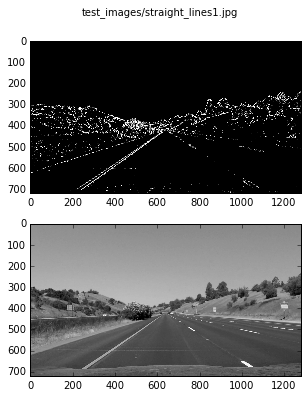

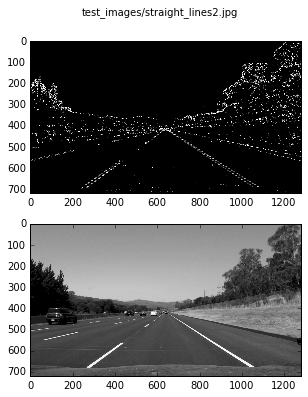

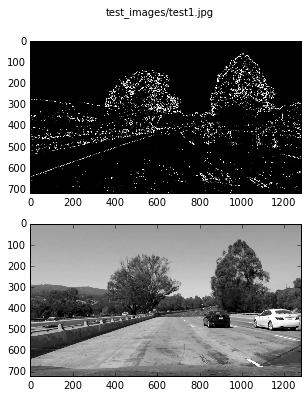

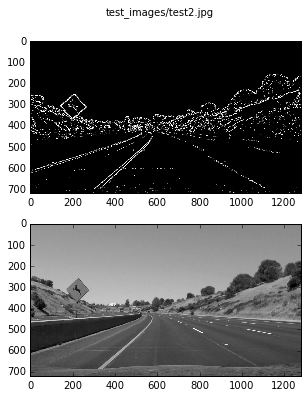

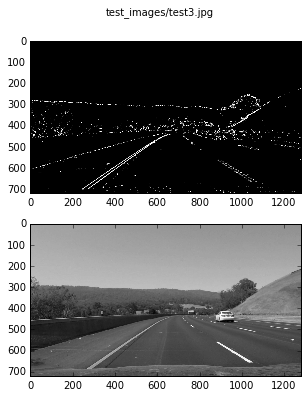

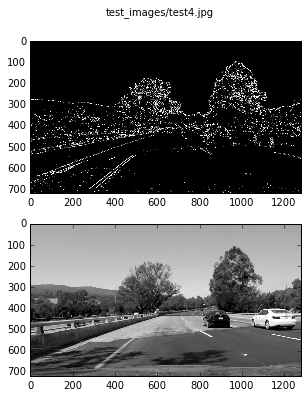

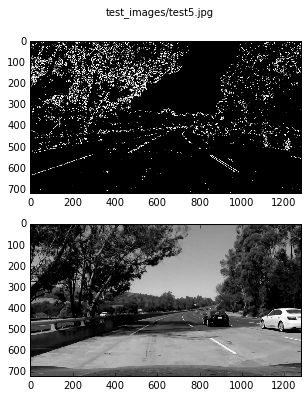

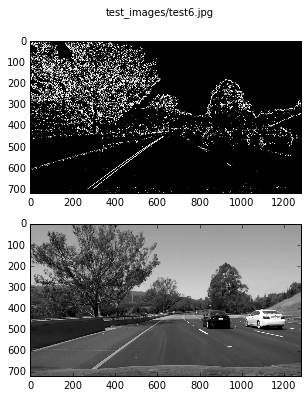

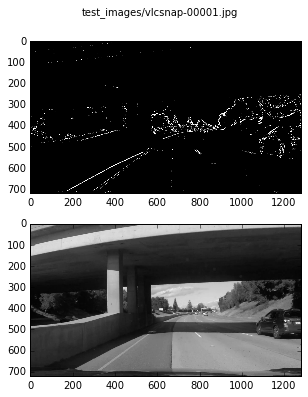

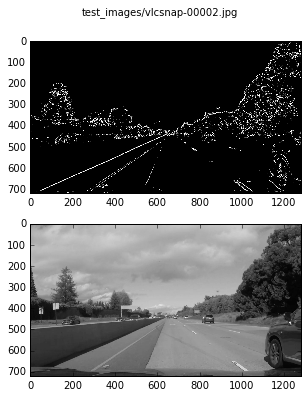

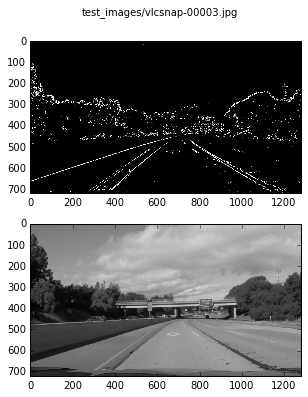

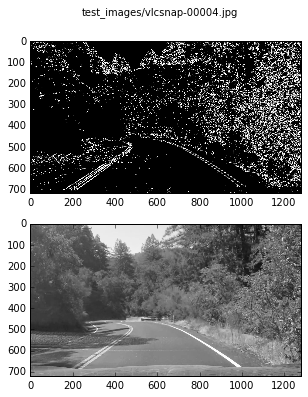

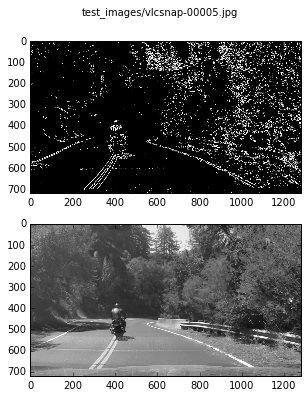

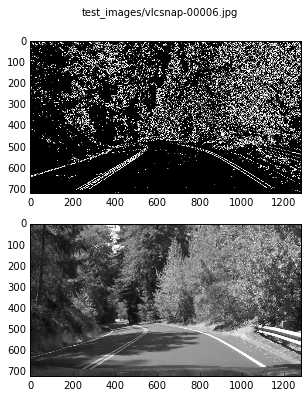

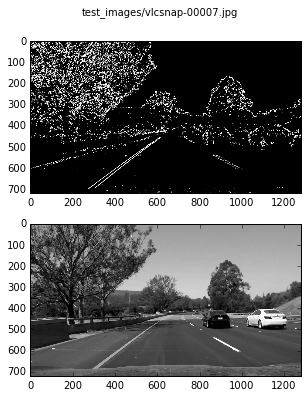

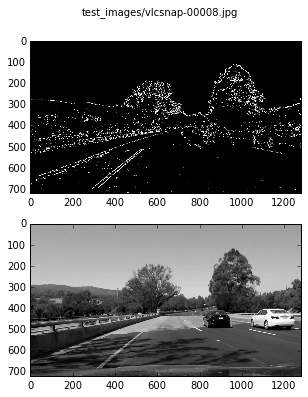

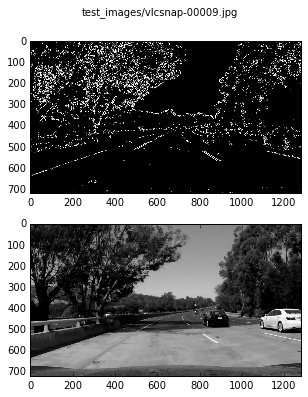

In [52]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

images=glob.glob("test_images/*.jpg")

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    
    # Get the image size.
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None,None)
  
    # Undistort the image
    dst = cv2.undistort(gray, mtx, dist, None, mtx)
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(dst, orient='x', sobel_kernel=ksize, thresh=(15, 100))
    grady = abs_sobel_thresh(dst, orient='y', sobel_kernel=ksize, thresh=(15, 100))
    mag_binary = mag_threshold(dst, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(dst, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(gray)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    fig = plt.figure(figsize=(6,6))
    fig.suptitle(fname)
    plt.subplot(211)
    plt.imshow(combined, cmap="gray")
    plt.subplot(212)
    plt.imshow(gray, cmap="gray")

## Perspective Correction
To identify the lane curvature we first need to change the perspective of the road. To achieve this we identify four points in a image of the road and map these to coordinates on our output image. We initially started with dots that were very close to the vanishing point, however this resulted in a lot of distortion. The distortion was most likely coming from the interpolation that was required to change two very close points to points with more than 800 pixels apart in the undistorted image. As a result we decided to choose points that were less far away and were only about 125 pixels spaced apart. This left sufficient room to come up with a good interpolation as we will see next.

Below we draw the dots on the original picture. Next we show examples of the perspective corrected view of three scenarios. The first is a curved line, the second a straight line and the third also a straight line.

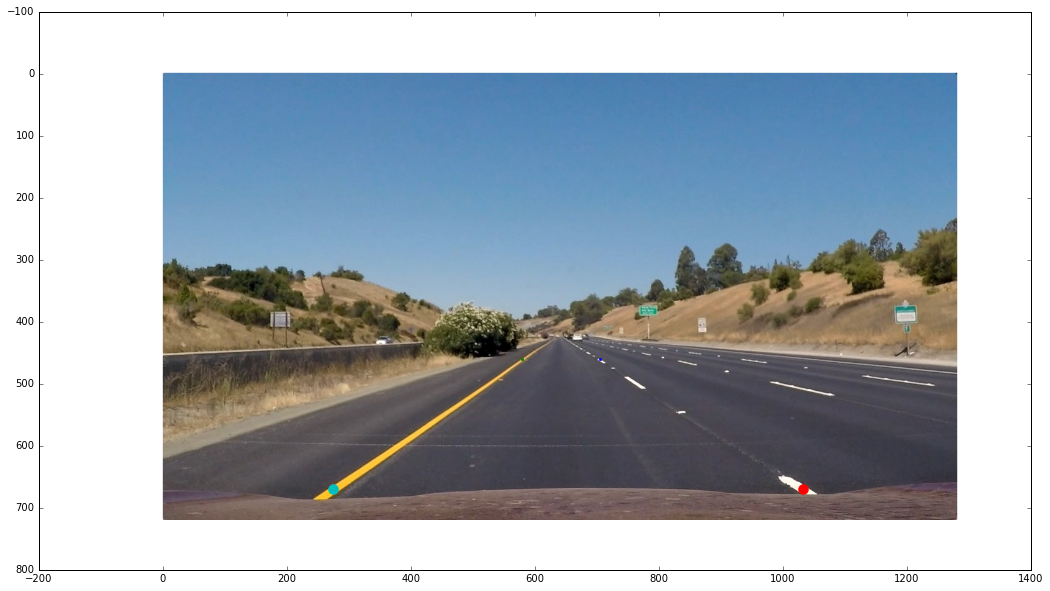

In [4]:
import matplotlib.image as mpimg

img = mpimg.imread('test_images/straight_lines1.jpg')
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.plot(705, 460, '.', markersize=5)
plt.plot(580, 460, '.', markersize=5)
plt.plot(1033, 670, '.', markersize=20)
plt.plot(275, 670, '.', markersize=20)

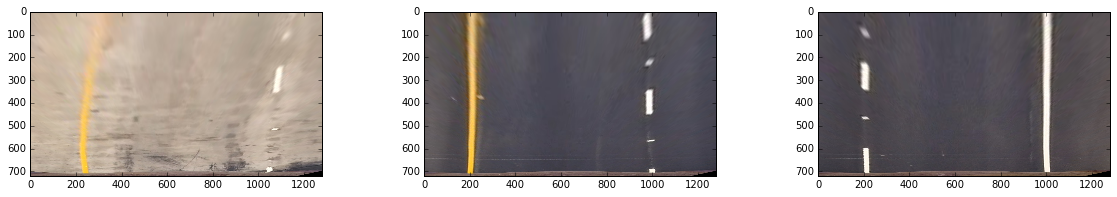

In [5]:
src_pnts = np.float32([[1033,670],          
                  [275,670],
                  [705,460],
                  [580,460]])          

dst_pnts = np.float32([[1000, 700],
                  [200, 700],
                  [1000, 0],
                  [200, 0]])
img_size = (img.shape[1], img.shape[0])
road_camera_M = cv2.getPerspectiveTransform(src_pnts, dst_pnts)
inv_road_camera_M = cv2.getPerspectiveTransform(dst_pnts, src_pnts)
img = mpimg.imread('test_images/test1.jpg')
warped = cv2.warpPerspective(img, road_camera_M, img_size, flags=cv2.INTER_CUBIC)
plt.figure(figsize=(20,10))
plt.subplot(331)
plt.imshow(warped)

img2 = mpimg.imread('test_images/straight_lines1.jpg')
warped = cv2.warpPerspective(img2, road_camera_M, img_size, flags=cv2.INTER_CUBIC)
plt.subplot(332)
plt.imshow(warped)

img3 = mpimg.imread('test_images/straight_lines2.jpg')
warped = cv2.warpPerspective(img3, road_camera_M, img_size, flags=cv2.INTER_CUBIC)
plt.subplot(333)
plt.imshow(warped)


## Threshold Settings
Let us inspect with some harder images what good values would be for the thresholds.

In [6]:
import matplotlib.gridspec as gridspec
import glob

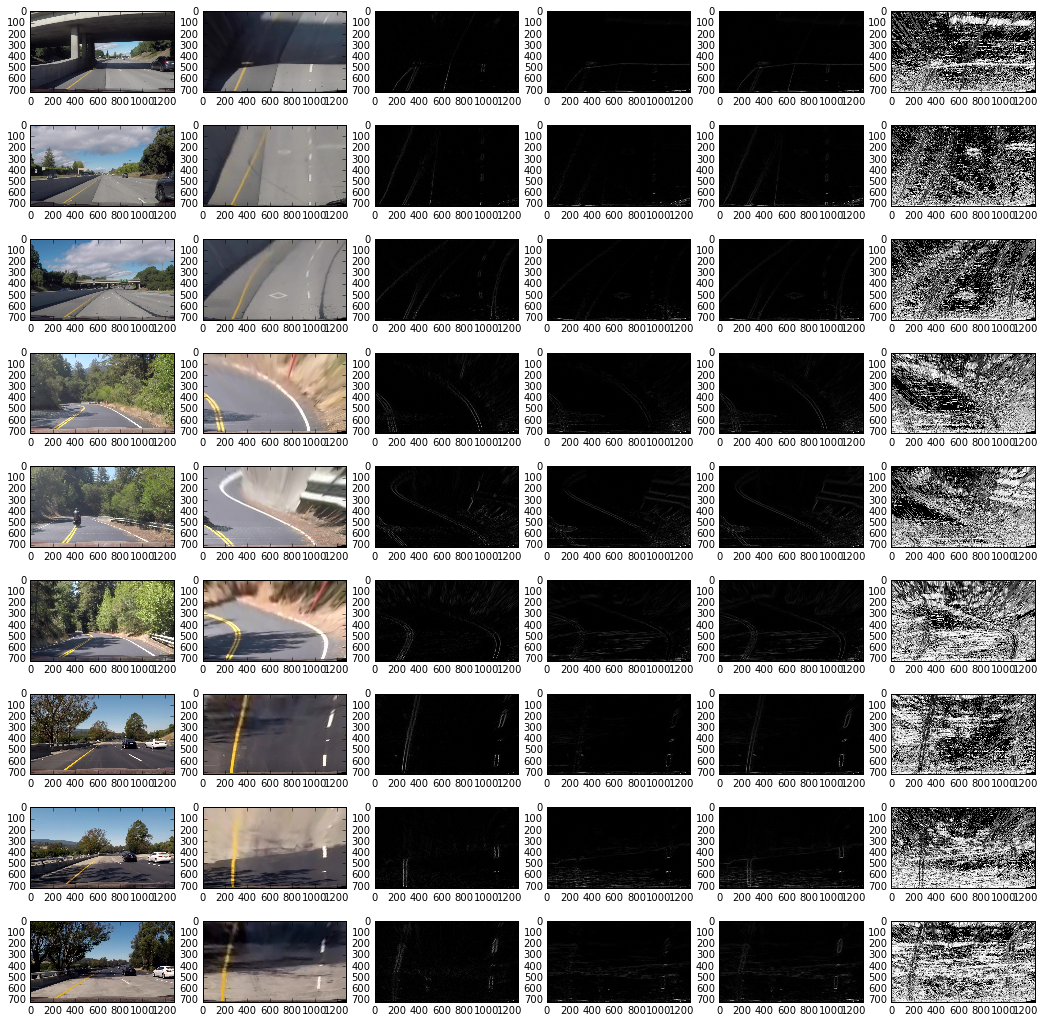

In [9]:
fig = plt.figure(figsize=(18, 18))
gs = gridspec.GridSpec(9, 6)

for i, img_nm in enumerate(glob.iglob('./test_images/vlcsnap*jpg')):
    img = cv2.imread(img_nm)
    ax = plt.subplot(gs[i * 6])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), cmap='gray')
    
    warped = cv2.warpPerspective(img, road_camera_M, img_size, flags=cv2.INTER_LANCZOS4)
    hsv = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)[:,:,2]
    ax = plt.subplot(gs[i * 6 + 1])
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_RGB2BGR), cmap='gray')
    
    abs_sobel = np.absolute(cv2.Sobel(hsv, cv2.CV_64F, 1, 0))
    sobel_x = np.uint8(255*abs_sobel/np.max(abs_sobel))
    ax = plt.subplot(gs[i * 6 + 2])
    plt.imshow(sobel_x, cmap='gray')
    
    abs_sobel = np.absolute(cv2.Sobel(hsv, cv2.CV_64F, 0, 1))
    sobel_y = np.uint8(255*abs_sobel/np.max(abs_sobel))
    ax = plt.subplot(gs[i * 6 + 3])
    plt.imshow(sobel_y, cmap='gray')
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(hsv, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(hsv, cv2.CV_64F, 0, 1, ksize=3)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    ax = plt.subplot(gs[i * 6 + 4])
    plt.imshow(gradmag, cmap='gray')
    
    sobelx = cv2.Sobel(hsv, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(hsv, cv2.CV_64F, 0, 1, ksize=3)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx)) / np.pi *255
    ax = plt.subplot(gs[i * 6 + 5])
    plt.imshow(absgraddir, cmap='gray')

We see that in certain shade condition the lines can be hard to identify.  Let us perform CLAHE adjustment to see whether we can highlight lines better.

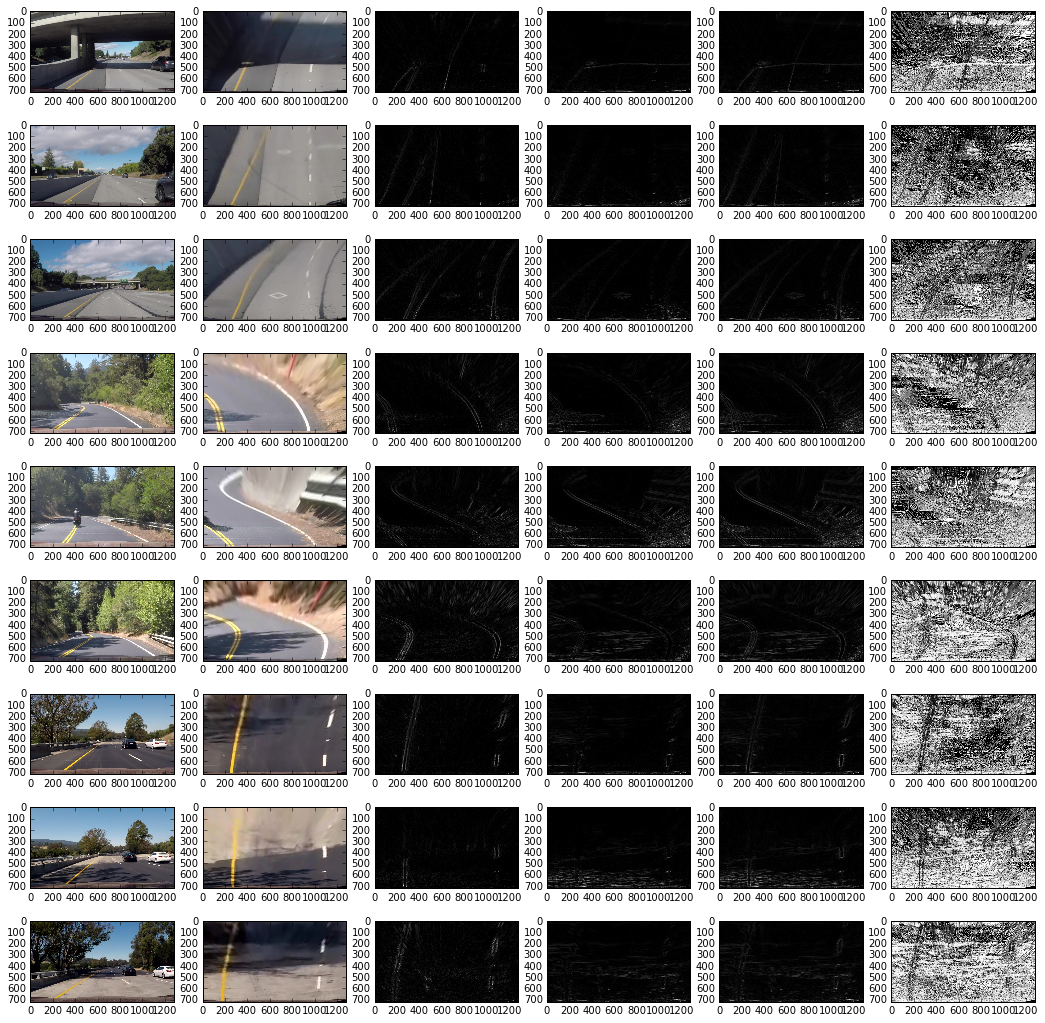

In [102]:
fig = plt.figure(figsize=(18, 18))
gs = gridspec.GridSpec(9, 6)

for i, img_nm in enumerate(glob.iglob('./test_images/vlcsnap*jpg')):
    img = cv2.imread(img_nm)
    ax = plt.subplot(gs[i * 6])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), cmap='gray')
    
    warped = cv2.warpPerspective(img, road_camera_M, img_size, flags=cv2.INTER_LANCZOS4)
    hsv = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)[:,:,2]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    hsv = clahe.apply(hsv)

    ax = plt.subplot(gs[i * 6 + 1])
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_RGB2BGR), cmap='gray')
    
    abs_sobel = np.absolute(cv2.Sobel(hsv, cv2.CV_64F, 1, 0))
    sobel_x = np.uint8(255*abs_sobel/np.max(abs_sobel))
    ax = plt.subplot(gs[i * 6 + 2])
    plt.imshow(sobel_x, cmap='gray')
    
    abs_sobel = np.absolute(cv2.Sobel(hsv, cv2.CV_64F, 0, 1))
    sobel_y = np.uint8(255*abs_sobel/np.max(abs_sobel))
    ax = plt.subplot(gs[i * 6 + 3])
    plt.imshow(sobel_y, cmap='gray')
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(hsv, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(hsv, cv2.CV_64F, 0, 1, ksize=3)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    ax = plt.subplot(gs[i * 6 + 4])
    plt.imshow(gradmag, cmap='gray')
    
    sobelx = cv2.Sobel(hsv, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(hsv, cv2.CV_64F, 0, 1, ksize=3)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx)) / np.pi *255
    ax = plt.subplot(gs[i * 6 + 5])
    plt.imshow(absgraddir, cmap='gray')

We see that the y direction for the Sobol operator does not contain much information. Moreover we see that the `arctan` identifies lines as low values, since the lines are black in the image. The gradient magnitude is less useful. Next we will try to increase the kernel size to see whether that can smoothen the results a bit.

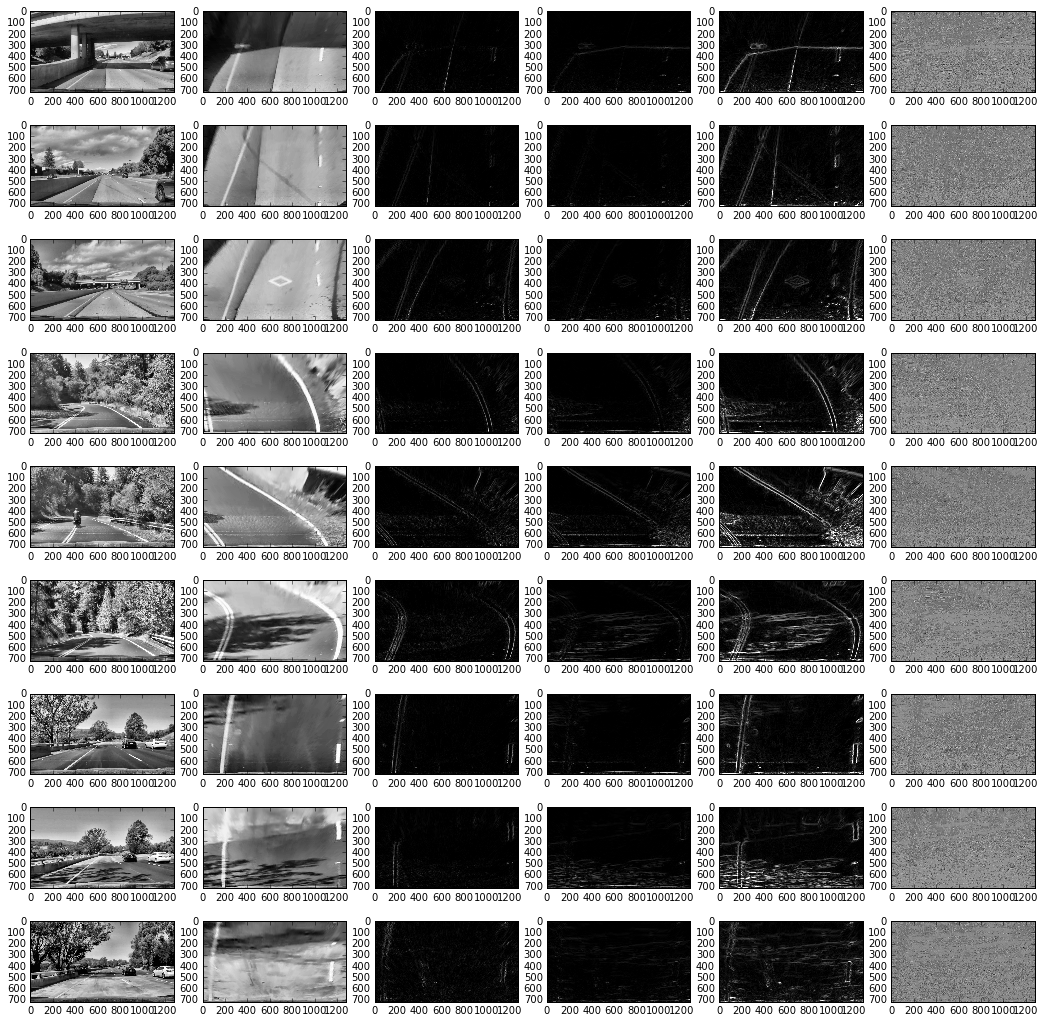

In [70]:
fig = plt.figure(figsize=(18, 18))
gs = gridspec.GridSpec(9, 6)

for i, img_nm in enumerate(glob.iglob('./test_images/vlcsnap*jpg')):
    img = cv2.imread(img_nm,0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    ax = plt.subplot(gs[i * 6])
    plt.imshow(img, cmap='gray')
    
    warped = cv2.warpPerspective(img, road_camera_M, img_size, flags=cv2.INTER_LANCZOS4)
    ax = plt.subplot(gs[i * 6 + 1])
    plt.imshow(warped, cmap='gray')
    
    abs_sobel = np.absolute(cv2.Sobel(warped, cv2.CV_64F, 1, 0, ksize=5))
    sobel_x = np.uint8(255*abs_sobel/np.max(abs_sobel))
    ax = plt.subplot(gs[i * 6 + 2])
    plt.imshow(sobel_x, cmap='gray')
    
    abs_sobel = np.absolute(cv2.Sobel(warped, cv2.CV_64F, 0, 1, ksize=5))
    sobel_y = np.uint8(255*abs_sobel/np.max(abs_sobel))
    ax = plt.subplot(gs[i * 6 + 3])
    plt.imshow(sobel_y, cmap='gray')
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(warped, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(warped, cv2.CV_64F, 0, 1, ksize=5)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    ax = plt.subplot(gs[i * 6 + 4])
    gradmag = cv2.filter2D(gradmag, -1, 3) 
    plt.imshow(gradmag, cmap='gray')
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx)) / np.pi *255
    ax = plt.subplot(gs[i * 6 + 5])
    kernel = np.array([[-0.5,-0.5,-0.5], [-0.5,5,-0.5], [-0.5,-0.5,-0.5]])
    absgraddir = cv2.filter2D(absgraddir, -1, kernel) 
    plt.imshow(absgraddir, cmap='gray') 

We see increasing the kernel has good results except on the arctan of the outcome of the Sobol operator. Let us use this information to set thresholds.

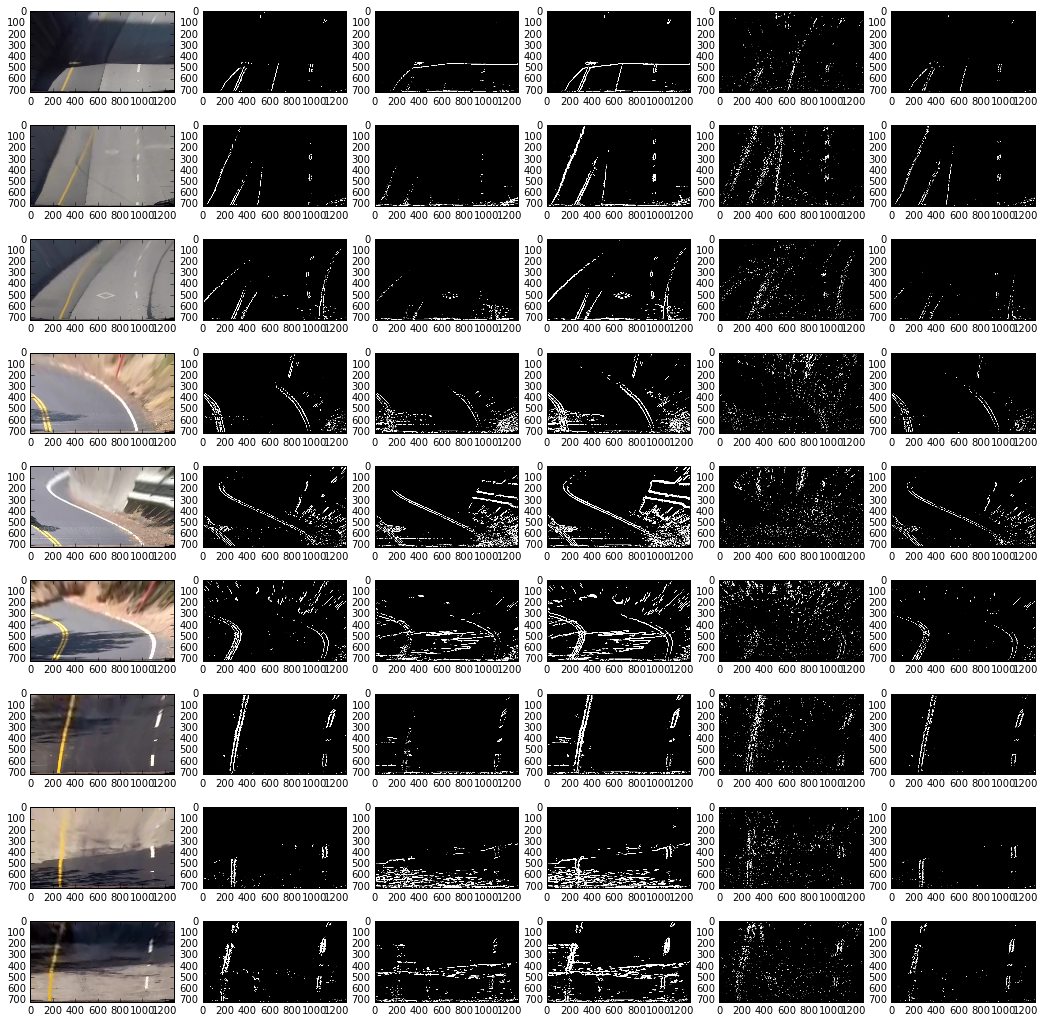

In [106]:
fig = plt.figure(figsize=(18, 18))
gs = gridspec.GridSpec(9, 6)

for i, img_nm in enumerate(glob.iglob('./test_images/vlcsnap*jpg')):
    img = cv2.imread(img_nm)
   
    warped = cv2.warpPerspective(img, road_camera_M, img_size, flags=cv2.INTER_CUBIC)
    ax = plt.subplot(gs[i * 6])
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_RGB2BGR), cmap='gray')
    
    hsv = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)[:,:,2]

    sobel_x = abs_sobel_thresh(hsv, orient='x', sobel_kernel=5, thresh=(20, 150))
    sobel_y = abs_sobel_thresh(hsv, orient='y', sobel_kernel=5, thresh=(15, 150))
    mag_binary = mag_threshold(hsv, sobel_kernel=5, mag_thresh=(15, 80))
    dir_binary = dir_threshold(hsv, sobel_kernel=3, thresh=(0.01, 0.3))

    ax = plt.subplot(gs[i * 6 + 1])
    plt.imshow(sobel_x, cmap='gray')
    
    ax = plt.subplot(gs[i * 6 + 2])
    plt.imshow(sobel_y, cmap='gray')
    
    ax = plt.subplot(gs[i * 6 + 3])
    plt.imshow(mag_binary, cmap='gray')
    
    ax = plt.subplot(gs[i * 6 + 4])
    plt.imshow(dir_binary, cmap='gray')
    
    combined = np.zeros_like(gray)
    combined[((sobel_x == 1) & (sobel_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    ax = plt.subplot(gs[i * 6 + 5])
    plt.imshow(combined, cmap='gray')


## Add Yellow and White Color Separation
We are going to add yellow and white color separation to be able to better spot the lines.

In [10]:
from lane_finding.thresholding import white_thresh, yellow_thresh, combined_sobel_thresh, isolate_lanes

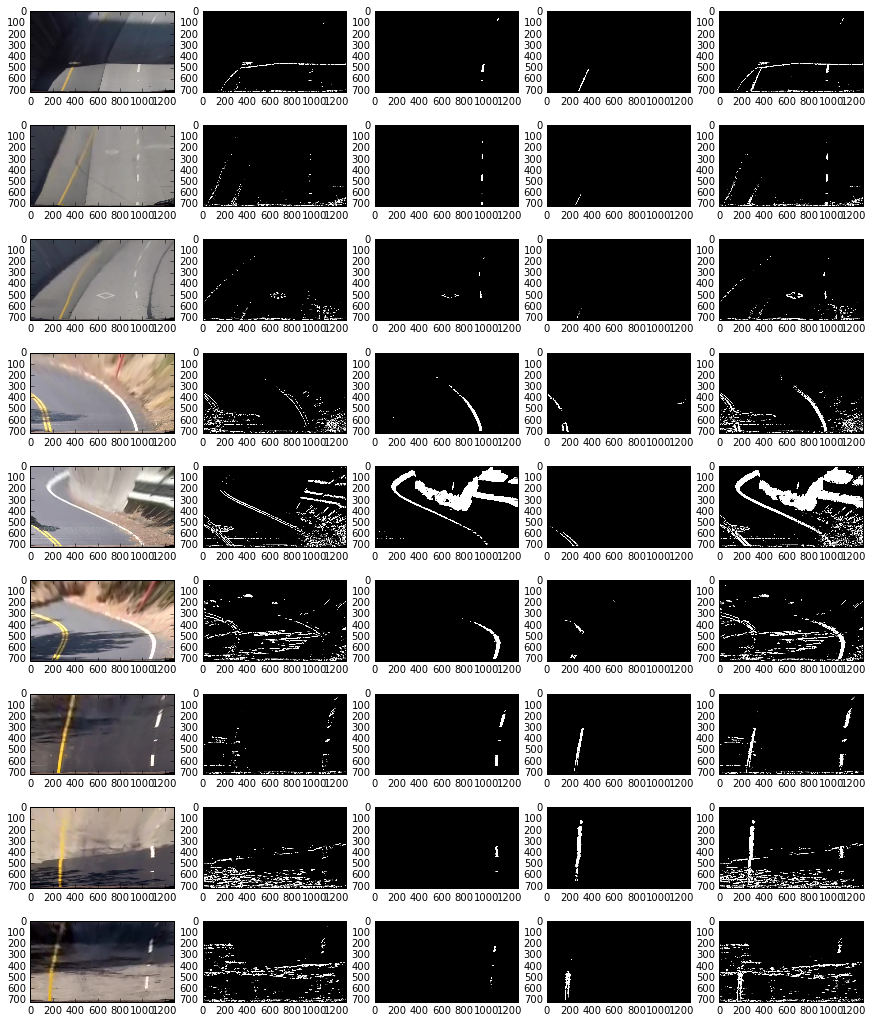

In [12]:
fig = plt.figure(figsize=(18, 18))
gs = gridspec.GridSpec(9, 6)

for i, img_nm in enumerate(glob.iglob('./test_images/vlcsnap*jpg')):
    img = cv2.imread(img_nm)
   
    warped = cv2.warpPerspective(img, road_camera_M, img_size, flags=cv2.INTER_CUBIC)
     
    ax = plt.subplot(gs[i * 6])
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_RGB2BGR))

    comb_sobol_mask = combined_sobel_thresh(warped, abs_kernel=5, abs_thresh_x=(20,150),
                                            abs_thresh_y=(15,150),
                                            mag_kernel=5, mag_thresh=(15,180),
                                            dir_kernel=3, dir_thresh=(0.01,0.3))

    ax = plt.subplot(gs[i * 6 + 1])
    plt.imshow(comb_sobol_mask, cmap='gray')
    
    white_col = white_thresh(warped)
    ax = plt.subplot(gs[i * 6 + 2])
    plt.imshow(white_col, cmap='gray')
    
    yellow_col = yellow_thresh(warped)
    ax = plt.subplot(gs[i * 6 + 3])
    plt.imshow(yellow_col, cmap='gray')
    
    lanes = isolate_lanes(warped)
    ax = plt.subplot(gs[i * 6 + 4])
    plt.imshow(lanes, cmap='gray')
      
    